In [51]:
# Import libraries.
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
# Read input data.
cust_data = pd.read_csv("raw_data/customer_data.csv")
trans_data = pd.read_csv("raw_data/transaction_data.csv")

# FX rate are for 1 GBP and assumes no change over time for simplicity.
fx_data = pd.read_csv("raw_data/fx_gbp.csv",header=1, skiprows=[0,2], usecols=["currency", "rate"])

# len(fx_data.currency.unique())
# len(trans_data.currency.unique())

In [53]:
print(fx_data.head())

  currency         rate
0      THB    37.386304
1      BIF  2242.924895
2      NGN   439.534518
3      LKR   214.801634
4      CHF     1.194301


In [54]:
print(trans_data.head())

   purchase_id  buyer_id country  product_id   department     category  \
0            3  10258663      AU   113961581  Accessories  Accessories   
1            6   9135670      AU   114780505  Accessories  Accessories   
2            9  10869093      AU   115216176  Accessories  Accessories   
3           27  10182131      AU   112217251  Accessories  Accessories   
4           31   5766224      AU   107519551  Accessories  Accessories   

  purchase_date currency  value_of_item  
0    02/08/2019      AUD           15.0  
1    02/08/2019      AUD           33.5  
2    07/08/2019      AUD           65.0  
3    02/08/2019      AUD           40.0  
4    02/08/2019      AUD           25.0  


In [55]:
print(cust_data.head())

   buyer_id gender  membership_length age_group
0       505      F                0.2     50-60
1      1989      F                0.8       60+
2      2234      F                0.4     50-60
3      2619      F                0.4     50-60
4      3392      F                2.3     50-60


#### Join datasets and perform checks on join

In [56]:
# Join trans_data with fx_gbp for fixed currency for analysis.
abt_trans = pd.merge(left=trans_data, right=fx_data, how="left", on="currency")
print(abt_trans.head())

   purchase_id  buyer_id country  product_id   department     category  \
0            3  10258663      AU   113961581  Accessories  Accessories   
1            6   9135670      AU   114780505  Accessories  Accessories   
2            9  10869093      AU   115216176  Accessories  Accessories   
3           27  10182131      AU   112217251  Accessories  Accessories   
4           31   5766224      AU   107519551  Accessories  Accessories   

  purchase_date currency  value_of_item      rate  
0    02/08/2019      AUD           15.0  1.799521  
1    02/08/2019      AUD           33.5  1.799521  
2    07/08/2019      AUD           65.0  1.799521  
3    02/08/2019      AUD           40.0  1.799521  
4    02/08/2019      AUD           25.0  1.799521  


In [57]:
# Check if there are any missing rates from the join.
sum(abt_trans['rate'].isna()) # Output shows all good.

0

In [58]:
# Standard value of item by calculating in gbp
abt_trans['gbp_value_of_item'] = abt_trans.value_of_item * abt_trans.rate
abt_trans.head()

,purchase_id,buyer_id,country,product_id,department,category,purchase_date,currency,value_of_item,rate,gbp_value_of_item
0,3,10258663,AU,113961581,Accessories,Accessories,02/08/2019,AUD,15.0,1.799521,26.992815
1,6,9135670,AU,114780505,Accessories,Accessories,02/08/2019,AUD,33.5,1.799521,60.283953
2,9,10869093,AU,115216176,Accessories,Accessories,07/08/2019,AUD,65.0,1.799521,116.968865
3,27,10182131,AU,112217251,Accessories,Accessories,02/08/2019,AUD,40.0,1.799521,71.980840
4,31,5766224,AU,107519551,Accessories,Accessories,02/08/2019,AUD,25.0,1.799521,44.988025


In [59]:
# Join abt_trans with cust_data for final abt. abt is the full table
abt = pd.merge(left=abt_trans, right=cust_data, how="left", on="buyer_id")
# abt

In [60]:
# Create dataset with full customer data
abt_cust = pd.merge(left=abt_trans, right=cust_data, how="inner", on="buyer_id")

In [61]:
# Create new table which displays aggregate data by buyer_id
abt_buyer_dev = abt_cust.drop(['rate', 'value_of_item'], axis=1)

# List col names to write col aggregation rules
list(abt_buyer_dev)

['purchase_id',
 'buyer_id',
 'country',
 'product_id',
 'department',
 'category',
 'purchase_date',
 'currency',
 'gbp_value_of_item',
 'gender',
 'membership_length',
 'age_group']

In [99]:
aggregation_rules = {
    'purchase_id': 'nunique',
    'country': 'nunique',
    'product_id': 'nunique',
    'department': 'nunique',
    'category': 'nunique',
    'purchase_date': 'nunique',
    'currency': 'nunique',
    'gbp_value_of_item': 'sum',
    'gender': 'first',
    'membership_length': 'first',
    'age_group': 'first'
}

new_column_names = {
    'purchase_id': 'n_purchase',
    'country': 'n_country',
    'product_id': 'n_product_id',
    'department': 'n_department',
    'category': 'n_category',
    'purchase_date': 'n_purchase_date',
    'currency': 'n_currency',
}

# Aggregate abt_buyer_dev into abt_buyer and sort by descending count of purchases by buyer
abt_buyer = abt_buyer_dev.groupby('buyer_id').agg(aggregation_rules).rename(columns=new_column_names).sort_values(by=['n_purchase'], ascending=[False])

abt_buyer

,n_purchase,n_country,n_product_id,n_department,n_category,n_purchase_date,n_currency,gbp_value_of_item,gender,membership_length,age_group
buyer_id,,,,,,,,,,,
15212141,182,1,182,3,3,7,1,2891.414956,M,0.1,50-60
15295957,84,1,84,6,7,4,1,1457.866498,F,0.1,30-40
8200744,74,1,74,2,4,7,1,2486.390000,F,0.4,50-60
15240485,71,1,2,1,1,4,1,1144.163782,F,0.1,30-40
15028370,64,1,60,1,1,5,1,77.817728,M,0.0,18-30
...,...,...,...,...,...,...,...,...,...,...,...
15361096,1,1,1,1,1,1,1,13.000000,M,0.1,30-40
15361309,1,1,1,1,1,1,1,12.159020,F,0.1,30-40
15361425,1,1,1,1,1,1,1,65.658708,F,0.5,60+


### Write data

In [100]:
abt.to_csv('cleaned_data/abt.csv', encoding='utf-8', index=False) # Full table at purchase_id
abt_buyer.to_csv('cleaned_data/abt_buyer.csv', encoding='utf-8', index=False) # Aggregated abt_cust table at buyer_id


abt_trans.to_csv('cleaned_data/abt_trans.csv', encoding='utf-8', index=False) # Transaction table only
abt_cust.to_csv('cleaned_data/abt_cust.csv', encoding='utf-8', index=False) # Transaction table with no blanks on customer data

## Exploratory Data Analysis

#### 1. Data distribution

In [68]:
# abt.info()
abt.describe()

#len(abt.index) #217977

,purchase_id,buyer_id,product_id,value_of_item,rate,gbp_value_of_item,membership_length
count,217977.000000,2.179770e+05,2.179770e+05,217977.000000,217977.000000,2.179770e+05,217757.000000
mean,119576.558096,8.703340e+06,1.084642e+08,25.903645,1.109567,1.045245e+02,0.256614
std,67270.417952,4.466001e+06,1.109690e+07,86.657022,1.013383,2.584318e+04,0.325394
min,1.000000,5.050000e+02,4.619240e+06,0.010000,1.000000,1.000000e-02,0.000000
25%,61898.000000,5.056861e+06,1.072332e+08,10.000000,1.000000,1.100000e+01,0.100000
50%,119058.000000,9.027800e+06,1.129410e+08,17.000000,1.000000,1.823853e+01,0.200000
75%,177250.000000,1.255774e+07,1.147439e+08,28.200000,1.215902,3.130948e+01,0.300000
max,237671.000000,1.536310e+07,1.156099e+08,33200.000000,358.290184,1.189523e+07,14.900000


In [70]:
# abt_cust.info()
abt_buyer.describe()

,purchase_id,country,product_id,department,category,purchase_date,currency,gbp_value_of_item,membership_length
count,129113.000000,129113.000000,129113.000000,129113.000000,129113.000000,129113.000000,129113.000000,1.291130e+05,129113.000000
mean,1.686561,1.686561,1.686561,1.686561,1.686561,1.686561,1.686561,1.762968e+02,0.287618
std,1.633121,1.633121,1.633121,1.633121,1.633121,1.633121,1.633121,3.357883e+04,0.382845
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e-02,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.599000e+01,0.100000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.916949e+01,0.200000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.471559e+01,0.300000
max,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,1.189523e+07,14.900000


Summary

Findings:
- 170 records, ~99.9%, of data with no customer data, so very high customer data acquisition. Opportunity to leverage this in retargeting.
- Each row is a unique purchase so there's an immediate opportunity to increase basket size.
- Buyers aren't making many repeat purchases within 7 day period as seen through median count for purchase_id from abt_buyer table summary statistics. This is reasonable for the apparel industry, so not a major opportunity.
- Buyers can purchase from local and non-local currencies. This increases fx risk and pricing rework required, but promotes accessibility and so, broadens consumer base.
- Purchases by gender is dominated by females at 76%.
- Purchases by age group are skewked to younger age group.
- Women's apparel is driving sales at a median value of £17.90 but median value of shoes at £35 could further increase order size significantly. Perhaps co-promotion, co-location instore and online, advertising showing the items paired together in an outfit. Perhaps an ide of T&L.
- Men's apparel at median value of £24, are comparatively higher vs Women's apparel at £17.9, yet customers are concentrated at Women's. Opportunity to acquire further male customers or leverage exisiting female customers to purchase men's items for gifting.

Distribution:
- GBP item value has a right-skew distribution, values are more concentrated to lower end.
- Similarly, for membership length, however this includes nulls.

#### Relationship between currency and country

In [71]:
# Check if currency = 'GBP' is only used in country = 'GB' due to intuition.
print(abt_trans[(abt_trans['currency'] == 'GBP') & (abt_trans['country'] != 'GB')].head())

# Warrants further exploration as per intuition.

      purchase_id  buyer_id country  product_id   department     category  \
1351        15394  15244480     RoW    47083009  Accessories  Accessories   
1386        15844  10237835      DE   115404303  Accessories  Accessories   
1418        16215  12271165     RoW   114976510  Accessories  Accessories   
1424        16292   9758568      DE   104409015  Accessories  Accessories   
1425        16324   6088950     RoW   114404956  Accessories  Accessories   

     purchase_date currency  value_of_item  rate  gbp_value_of_item  
1351    07/08/2019      GBP          51.00   1.0              51.00  
1386    07/08/2019      GBP           8.00   1.0               8.00  
1418    07/08/2019      GBP          90.00   1.0              90.00  
1424    02/08/2019      GBP         158.99   1.0             158.99  
1425    01/08/2019      GBP          34.00   1.0              34.00  


In [72]:
# Calculate count of payments from each unique country current. Sorts by country ascending and count descending.

payment_types = abt_trans[['country','currency']]
unique_payment_types = payment_types.groupby(list(payment_types.columns)).size().reset_index(name='count').sort_values(by=['country', 'count'], ascending=[True, False])

unique_payment_types

# Customers are able to pay from a variety of currencies and not just local currency. This promotes accessibility but introduces fx risk if not mitigated by additional and more frequent work on pricing strategies.

,country,currency,count
0,AU,AUD,6828
4,AU,GBP,270
7,AU,USD,182
3,AU,EUR,18
1,AU,CAD,14
...,...,...,...
60,US,HUF,1
62,US,MYR,1
64,US,SEK,1
66,US,THB,1


#### Percent of customer data available

In [73]:
abt_nulls = abt[abt.isna().any(axis=1)]

In [74]:
# len(trans_data['buyer_id'].unique()) #129283 unique buyer_id from transactions

# cust_data.shape #(129113,4)
# len(cust_data['buyer_id'].unique()) #129113 unique buyer_id records

# abt_nulls.shape #(220, 14) so
# len(abt_nulls['buyer_id'].unique()) #170 unique buyer_id where no customer record

# (129283-170)/129283 *100
# 99.9% customer data for the 1 week purchase window.

# abt.shape #(217977, 14)
# sum(abt['gender'].isna()) # 220

# (217977-220)/217977 *100
# 99.9% of transactions records have customer data showing

#### Time periods in analysis

In [75]:
# Date analysis of data to understand if index year ago (this year / last year) can be calculated

abt.purchase_date.unique()

# Data is limited to one week
# 01/08/2019 = Thursday
# 02/08/2019 = Friday
# 03/08/2019 = Saturday
# 04/08/2019 = Sunday
# 05/08/2019 = Monday
# 06/08/2019 = Tuesday
# 07/08/2019 = Wednesday
# 03/08/2019 = Saturday

array(['02/08/2019', '07/08/2019', '03/08/2019', '01/08/2019',
       '06/08/2019', '04/08/2019', '05/08/2019'], dtype=object)

#### Product dimensions: Relationship between department and category

In [76]:
# Explore product dimension
abt.department.unique()

array(['Accessories', 'Beauty', 'Mens apparel', 'Womens apparel', 'Home',
       'Jewellery', 'Kids', 'Shoes', 'Tech'], dtype=object)

In [77]:
# Explore relationship between category and department. By intuition, category is more granular.

cat_dep = abt[['category', 'department']].drop_duplicates().sort_values(by=['department', 'category'])
#.size().reset_index(name='count').sort_values(by=['category', 'department'], ascending=[True, False])
print(cat_dep)

# For prod_dim L1 = department, L2 = category

                category      department
0            Accessories     Accessories
20690             Beauty          Beauty
81942               Home            Home
85336          Jewellery       Jewellery
99893               Kids            Kids
28926     Bottoms - Mens    Mens apparel
113246  Outerwear - Mens    Mens apparel
141930       Tops - Mens    Mens apparel
117320             Shoes           Shoes
138654              Tech            Tech
34629   Bottoms - Womens  Womens apparel
63681            Dresses  Womens apparel
101989          Lingerie  Womens apparel
107135         Outerwear  Womens apparel
174012     Tops - Womens  Womens apparel


In [78]:
# Demographic analysis: Gender, Age Group, Membership Length

# Grouping by gender, age group, and membership length to analyse purchase patterns
gender_analysis = abt.groupby('gender')['gbp_value_of_item'].agg(['count', 'sum', 'median'])
age_group_analysis = abt.groupby('age_group')['gbp_value_of_item'].agg(['count', 'sum', 'median'])
membership_length_analysis = abt.groupby(pd.cut(abt['membership_length'], bins=[0, 1, 5, 10, 15]))['gbp_value_of_item'].agg(['count', 'sum', 'median'])

# Display the results
gender_analysis, age_group_analysis, membership_length_analysis

/var/folders/70/nwp36t1x5cs_z_7xqgkk67_c0000gn/T/ipykernel_74303/2793464428.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  membership_length_analysis = abt.groupby(pd.cut(abt['membership_length'], bins=[0, 1, 5, 10, 15]))['gbp_value_of_item'].agg(['count', 'sum', 'median'])


(         count           sum     median
 gender                                 
 F       165988  2.002580e+07  17.934555
 M        51769  2.736409e+06  22.000000,
            count           sum    median
 age_group                               
 18-30      38794  1.303864e+07  18.23853
 30-40      76972  5.272295e+06  18.20000
 40-50      43577  2.122050e+06  18.23853
 50-60      34928  1.625724e+06  18.23853
 60+        23486  7.034983e+05  18.23853,
                     count           sum      median
 membership_length                                  
 (0, 1]             207072  2.164507e+07    18.23853
 (1, 5]               4601  1.019999e+06   156.00000
 (5, 10]                95  6.367811e+04   613.61825
 (10, 15]               10  1.255773e+04  1120.17625)

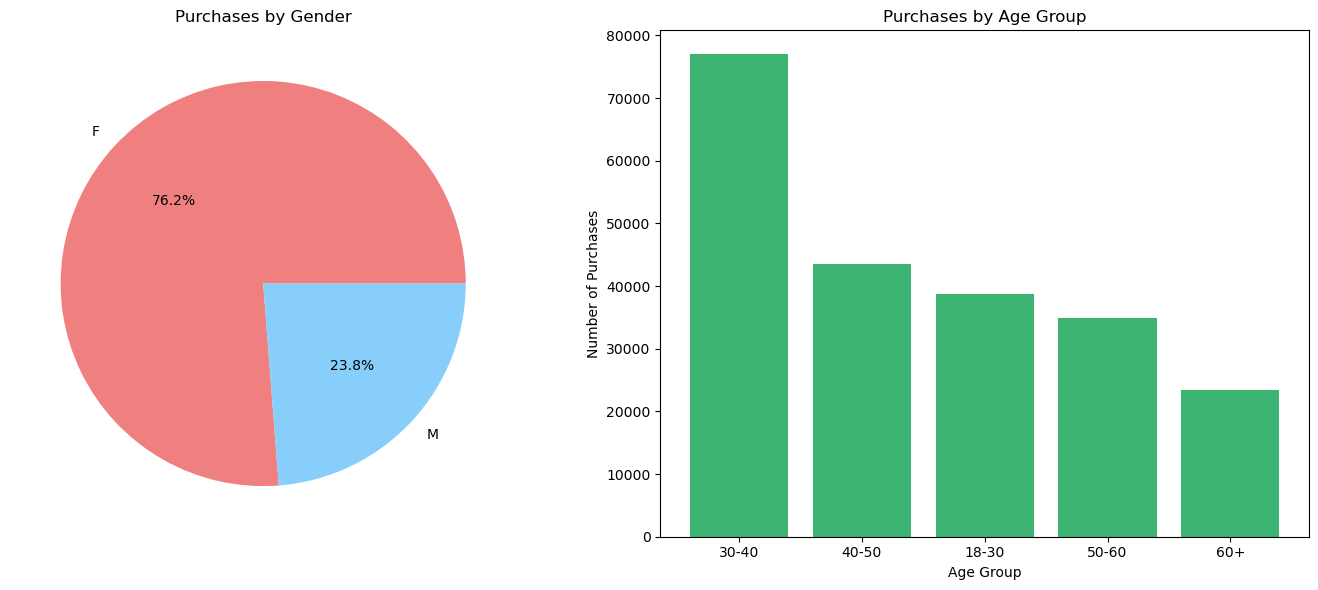

"\nmembership_summary = abt['membership_length'].describe()\n\ngender_distribution, age_group_distribution, membership_summary\n"

In [81]:
# Analyse the demographic breakdown based on gender and age group
gender_distribution = abt['gender'].value_counts()
age_group_distribution = abt['age_group'].value_counts()

# Plot the distribution of purchases by gender and age group
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Gender distribution
axs[0].pie(gender_distribution, labels=gender_distribution.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
axs[0].set_title('Purchases by Gender')

# Age group distribution
axs[1].bar(age_group_distribution.index, age_group_distribution.values, color='mediumseagreen')
axs[1].set_title('Purchases by Age Group')
axs[1].set_xlabel('Age Group')
axs[1].set_ylabel('Number of Purchases')

plt.tight_layout()
plt.show()

# Analyse membership length distribution. Not used as we later use abt_buyer table as abt will skew membership data if multiple purchases by members.

"""
membership_summary = abt['membership_length'].describe()

gender_distribution, age_group_distribution, membership_summary
"""

In [80]:
# Product Categories & Departments Analysis

# Grouping by department and category to analyze purchase trends
department_analysis = abt.groupby('department')['gbp_value_of_item'].agg(['count', 'sum', 'median']).sort_values(by='sum', ascending=False)
category_analysis = abt.groupby('category')['gbp_value_of_item'].agg(['count', 'sum', 'median']).sort_values(by='sum', ascending=False)

# Display the results
department_analysis, category_analysis


(                 count           sum     median
 department                                     
 Womens apparel  102535  1.649360e+07  17.934555
 Accessories      20690  2.975625e+06  16.490000
 Mens apparel     41859  1.472028e+06  23.990000
 Shoes            21334  1.209966e+06  35.000000
 Jewellery        14557  2.446906e+05  10.335167
 Tech              3276  1.497778e+05  18.238530
 Beauty            8236  1.241129e+05  11.000000
 Home              3394  8.072199e+04  15.806726
 Kids              2096  3.342004e+04  10.970000,
                   count           sum     median
 category                                        
 Tops - Womens     43965  1.367365e+07  16.000000
 Accessories       20690  2.975625e+06  16.490000
 Dresses           18261  1.792043e+06  18.500000
 Shoes             21334  1.209966e+06  35.000000
 Tops - Mens       32082  1.079116e+06  23.000000
 Bottoms - Womens  29052  7.181259e+05  18.000000
 Jewellery         14557  2.446906e+05  10.335167
 Outerwear

In [87]:
# Purchase Patterns: High-Value Customers and Common Purchase Behaviors

# Identifying high-value customers based on total spending
customer_spending = abt.groupby('buyer_id')['gbp_value_of_item'].agg(['count', 'sum', 'median']).sort_values(by='sum', ascending=False)

# Calculating overall purchase frequency and average spending
overall_purchase_behavior = {
    'total_purchases': abt['purchase_id'].count(),
    'total_customers': abt['buyer_id'].nunique(),
    'median_purchases_per_customer': abt.groupby('buyer_id')['purchase_id'].count().median(),
    'median_spend_per_customer': customer_spending['sum'].median(),
    'median_spend_per_purchase': abt['gbp_value_of_item'].median()
}

# Displaying the top 10 high-value customers and the overall purchase behavior
high_value_customers = customer_spending.head(10)
high_value_customers, overall_purchase_behavior


(          count           sum        median
 buyer_id                                   
 11335429      1  1.189523e+07  1.189523e+07
 5912384       4  1.360822e+06  2.044500e+01
 15296696      1  8.397880e+05  8.397880e+05
 14477331      1  8.164606e+05  8.164606e+05
 8039416       1  7.127830e+05  7.127830e+05
 2292959       1  5.831861e+05  5.831861e+05
 4941271       1  9.785443e+04  9.785443e+04
 3040083       2  4.116141e+04  2.058071e+04
 2797773       2  2.562069e+04  1.281034e+04
 11121054      1  2.340394e+04  2.340394e+04,
 {'total_purchases': 217977,
  'total_customers': 129283,
  'median_purchases_per_customer': 1.0,
  'median_spend_per_customer': 29.181648000000003,
  'median_spend_per_purchase': 18.23853})

In [102]:
abt_buyer.groupby("n_purchase").count() # First record shows 85704 buyers made just one order in the week.

,n_country,n_product_id,n_department,n_category,n_purchase_date,n_currency,gbp_value_of_item,gender,membership_length,age_group
n_purchase,,,,,,,,,,
1,85704,85704,85704,85704,85704,85704,85704,85704,85704,85704
2,24453,24453,24453,24453,24453,24453,24453,24453,24453,24453
3,9158,9158,9158,9158,9158,9158,9158,9158,9158,9158
4,4359,4359,4359,4359,4359,4359,4359,4359,4359,4359
5,2171,2171,2171,2171,2171,2171,2171,2171,2171,2171
6,1177,1177,1177,1177,1177,1177,1177,1177,1177,1177
7,733,733,733,733,733,733,733,733,733,733
8,423,423,423,423,423,423,423,423,423,423
9,267,267,267,267,267,267,267,267,267,267
